In [ ]:
import pandas as pd
import os
from IPython.display import Image, display
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import Dataset , DataLoader
import cv2
import torch
import torchvision
from glob import glob
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

# **EDA:**

In [ ]:
df = pd.read_csv('/content/train.csv')
df.isnull().any()

image_id    False
width       False
height      False
bbox        False
source      False
dtype: bool

In [ ]:
df[['x_min','Y_min','X_max','Y_max']] = np.stack(df['bbox'].\
                                        apply(lambda x : [json.loads(x)[0],json.loads(x)[1],\
                                        (json.loads(x)[0]+json.loads(x)[2]),(json.loads(x)[1] + json.loads(x)[3])]))

In [ ]:
df_new = df.drop(['width','height','bbox','source'],axis =1)
df_new['image_id'] = df_new['image_id'].apply(lambda x : 'train/' + x + '.jpg') 
df_new.head(10)

image_id  x_min  Y_min   X_max  Y_max
0  train/b6ab77fd7.jpg  834.0  222.0   890.0  258.0
1  train/b6ab77fd7.jpg  226.0  548.0   356.0  606.0
2  train/b6ab77fd7.jpg  377.0  504.0   451.0  664.0
3  train/b6ab77fd7.jpg  834.0   95.0   943.0  202.0
4  train/b6ab77fd7.jpg   26.0  144.0   150.0  261.0
5  train/b6ab77fd7.jpg  569.0  382.0   688.0  493.0
6  train/b6ab77fd7.jpg   52.0  602.0   134.0  647.0
7  train/b6ab77fd7.jpg  627.0  302.0   749.0  377.0
8  train/b6ab77fd7.jpg  412.0  367.0   480.0  449.0
9  train/b6ab77fd7.jpg  953.0  220.0  1009.0  323.0

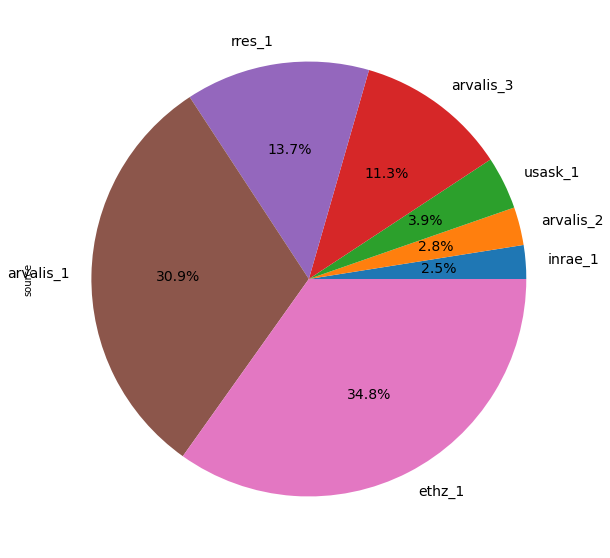

In [ ]:
plt.subplots(figsize=(15,10))

ax = df['source'].value_counts().sort_values().plot(kind = 'pie', autopct='%1.1f%%', fontsize=14)

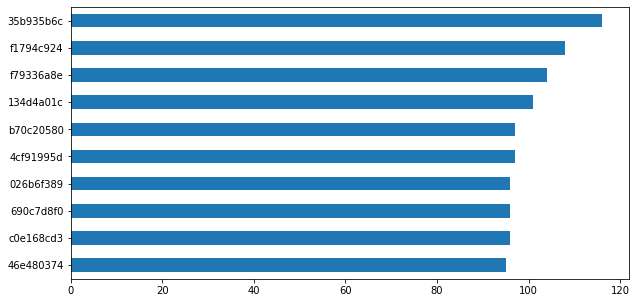

In [ ]:
from pandas.core.arrays.numeric import annotations
plt.subplots(figsize=(10,5))

ax = df['image_id'].value_counts()[:10].sort_values().plot(kind = 'barh')

In [ ]:
min_count = df['image_id'].value_counts().min()
max_count = df['image_id'].value_counts().max()
print('maximum bounding boxes present for an image are :',max_count)
print('minimum bounding boxes present for an image is :',min_count)

maximum bounding boxes present for an image are : 116
minimum bounding boxes present for an image is : 1


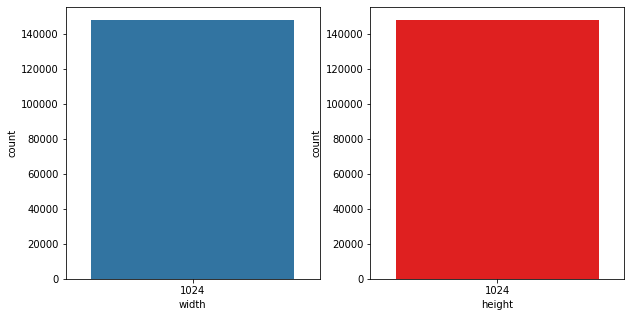

In [ ]:
# importing the required library
 
import seaborn as sns
import matplotlib.pyplot as plt
 
# read a tips.csv file from seaborn library

plt.subplots(1,2,figsize=(10,5))
# count plot on single categorical variable
plt.subplot(1,2,1)
sns.countplot(x ='width', data = df)
plt.subplot(1,2,2)
sns.countplot(x ='height', data = df,color='red')
# Show the plot
plt.show()

## **Train & Test Split :**

In [ ]:
train_data , validation_data = train_test_split(df_new['image_id'].unique(),test_size=0.1,random_state=42)
print('total train data points :',len(train_data))
print('total validation data points :',len(validation_data))

total train data points : 3035
total validation data points : 338


In [ ]:
train_df =  df_new[df_new['image_id'].isin([i for i in train_data])]
valid_df =  df_new[df_new['image_id'].isin([i for i in validation_data])]
train_df['labels'] = [1] * train_df.shape[0]
valid_df['labels'] = [1] * valid_df.shape[0]
print('Train data shape',train_df.shape)
print('Validation data shape',valid_df.shape)

Train data shape (133185, 6)
Validation data shape (14608, 6)


In [ ]:
train_df.head()

image_id  x_min  Y_min  X_max  Y_max  labels
0  train/b6ab77fd7.jpg  834.0  222.0  890.0  258.0       1
1  train/b6ab77fd7.jpg  226.0  548.0  356.0  606.0       1
2  train/b6ab77fd7.jpg  377.0  504.0  451.0  664.0       1
3  train/b6ab77fd7.jpg  834.0   95.0  943.0  202.0       1
4  train/b6ab77fd7.jpg   26.0  144.0  150.0  261.0       1

In [ ]:
def get_aug_pipeline() :
    transform = []
    transform.append(ToTensorV2(p=1))

    return A.Compose(transform, bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

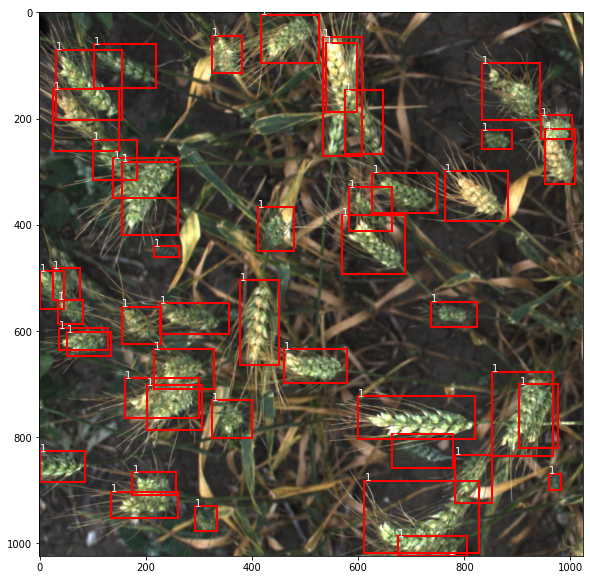

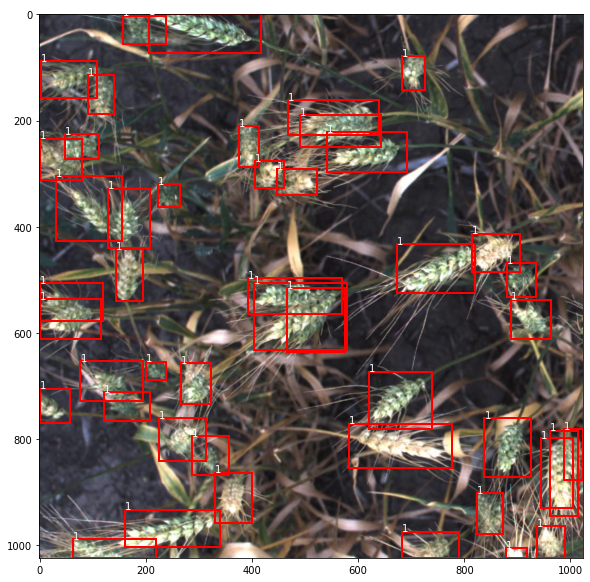

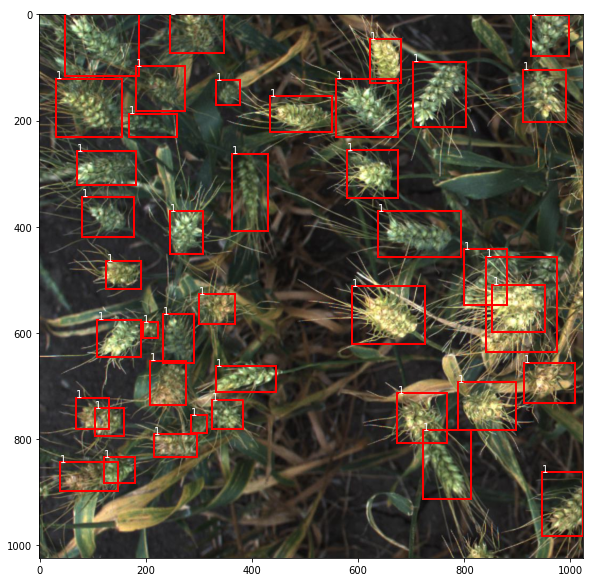

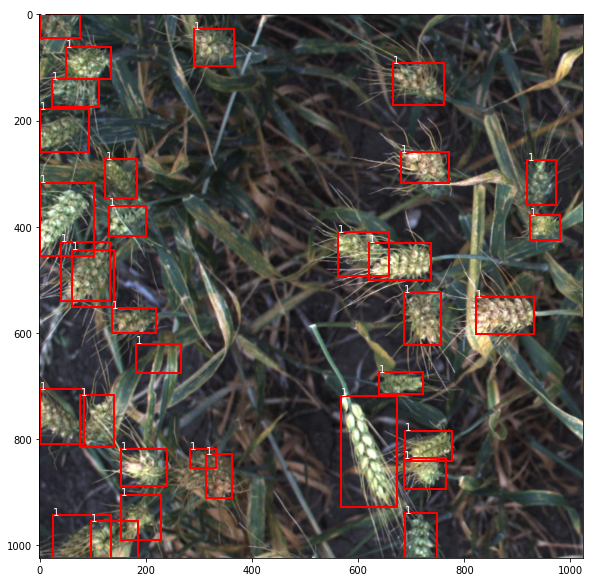

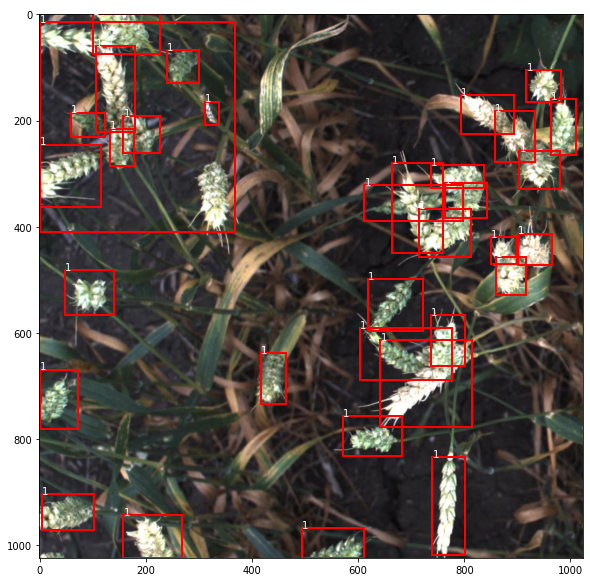

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches


def show_output_with_bbox(filename, bboxes, labels, transform):

    image = cv2.imread(filename) # cv2.IMREAD_COLOR
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image = image/255.0

    aug_pipeline = get_aug_pipeline()
    transformed = aug_pipeline(image=image, bboxes=bboxes, labels=labels)

    img = transformed['image']
    bboxes = torch.as_tensor(transformed['bboxes'])
    bboxes = bboxes.detach().numpy()
    labels = transformed['labels']
    
    img_height = img.shape[1]
    img_width = img.shape[2]
    
    fig, ax = plt.subplots(figsize=(10,10))

    ax.imshow(img.permute(1,2,0).numpy())

    for bbox, class_name in zip(bboxes, labels):
        xmin = bbox[0]
        ymin = bbox [1]
        width = bbox[2] - xmin
        height = bbox[3] - ymin
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin, class_name, color='w')
    
    
    plt.show()




################################################################################

trainFiles = train_df['image_id'].unique().tolist()
trainFiles = trainFiles[:5]

for filename in trainFiles:
    records = train_df[train_df['image_id']==filename]
    bboxes = records[['x_min', 'Y_min' , 'X_max' , 'Y_max']].values
    labels = records[['labels']].values
    labels = [x[0] for x in labels]
    area = (bboxes[:,2]-bboxes[:,0]) * (bboxes[:,3]-bboxes[:,1])
    show_output_with_bbox(filename, bboxes, labels, get_aug_pipeline())


In [ ]:
from albumentations.pytorch.transforms import ToTensorV2

# https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
# https://albumentations.ai/docs/api_reference/core/composition/


# global class_int_dict
class_int_dict = {
    "background":0,
    "1":1,
  
}

In [ ]:
def normal():
    return A.Compose([ToTensorV2(p=1)],
                      bbox_params=A.BboxParams(format='pascal_voc', min_area=0.0, min_visibility=0.0, label_fields=['labels']))

In [ ]:
class WheatDataset(Dataset):
    
    def __init__(self, DF, train):

        self.train = train
        self.DF = DF
        self.filenames = self.DF['image_id'].unique()
        self.noOfUniqueFiles = len(self.filenames)
        self.normal = normal()
        self.transforms = None

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, index):

        transformed = None    
        image_id = self.filenames[index]
        records = self.DF[self.DF['image_id'] == image_id]
        img = cv2.imread(image_id, cv2.IMREAD_ANYCOLOR) # cv2.IMREAD_COLOR
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img = img/255.0

        bboxes = records[['x_min', 'Y_min' , 'X_max' , 'Y_max']].values.tolist()
        class_labels = records[['labels']].values.reshape(1, -1)[0]
        class_labels = [class_int_dict[str(i)] for i in class_labels]

        if self.train:

            self.transforms = self.normal
            transformed = self.transforms(image=img, bboxes=bboxes, labels=class_labels)
      
        else:
            self.transforms = self.normal
            transformed = self.transforms(image=img, bboxes=bboxes, labels=class_labels)

        
        img = transformed['image']
        bboxes = torch.as_tensor(transformed['bboxes'], dtype=torch.float32)

        num_objs = len(bboxes)
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        class_label = torch.tensor(transformed['labels'])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["labels"] = class_label # tensor
        target["boxes"] = bboxes # tensor
        target['image_id'] = torch.tensor([index]) # string
        target['iscrowd'] = iscrowd
        target['area'] = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])

        return img, target

In [ ]:
train_dataset = WheatDataset(DF = train_df, train=True)

valid_dataset = WheatDataset(DF = valid_df, train=False)


def collate_fn(batch):
    return tuple(zip(*batch))

train_data_loader = DataLoader(
    train_dataset,
    batch_size = 5,
    shuffle = True,
    num_workers = 2,
    collate_fn = collate_fn
)


valid_data_loader = DataLoader(
    valid_dataset,
    batch_size = 3,
    shuffle = True,
    num_workers = 2,
    collate_fn = collate_fn
)


In [ ]:
SSD_MODEL = torchvision.models.detection.ssdlite320_mobilenet_v3_large(pretrained=False, num_classes=2)
SSD_MODEL
def getDevice():
    return torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device = getDevice()
device

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


  0%|          | 0.00/21.1M [00:00<?, ?B/s]

device(type='cpu')

In [ ]:
!git clone https://github.com/pytorch/vision.git

Cloning into 'vision'...
remote: Enumerating objects: 265612, done.
remote: Counting objects: 100% (4813/4813), done.
remote: Compressing objects: 100% (279/279), done.
remote: Total 265612 (delta 4545), reused 4768 (delta 4524), pack-reused 260799
Receiving objects: 100% (265612/265612), 536.22 MiB | 22.60 MiB/s, done.
Resolving deltas: 100% (242296/242296), done.


In [ ]:
!ln -s ./vision/references/detection/engine.py engine.py
!ln -s ./vision/references/detection/train.py train.py
!ln -s ./vision/references/detection/utils.py utils.py
!ln -s ./vision/references/detection/coco_utils.py coco_utils.py
!ln -s ./vision/references/detection/group_by_aspect_ratio.py group_by_aspect_ratio.py
!ln -s ./vision/references/detection/presets.py presets.py
!ln -s ./vision/references/detection/coco_eval.py coco_eval.py
!ln -s ./vision/references/detection/transforms.py transforms.py

In [ ]:
from engine import train_one_epoch, evaluate
import utils

In [ ]:
torch.cuda.empty_cache()

def getDevice():
    return torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device = getDevice()
device
if torch.cuda.is_available():
    SSD_MODEL.cuda()

params = [p for p in SSD_MODEL.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.0005)
EPOCHS = 10

loss_stats = {
    'train': [],
    "epoch": []
}
# TRAINING
print("Begin training.")
for e in range(EPOCHS):
    print("Epoch Number is :",e)
    epoch_loss = []
    SSD_MODEL.train()
    for i, data in tqdm(enumerate(train_data_loader)):
        # data of each batch
        images, targets = data
        # images, targets = images.cuda(), targets.cuda()
        optimizer.zero_grad()
         # copy data to cuda
        inputs = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # pass input to model
        loss_dict_train = SSD_MODEL(inputs, targets)

        # loss
        losses_train = sum(loss for loss in loss_dict_train.values())
        epoch_loss.append(losses_train.item())

        # backprop
        losses_train.backward()

        # update weights
        optimizer.step()
        #------====------#
    
    # Epoch end - Training loss
    train_loss_epoch = np.mean(epoch_loss)
    loss_stats['train'].append(train_loss_epoch)
    loss_stats['epoch'].append(e)
    

#VALIDATION 
    print("\nBegin Validation.")   
    coco_evaluater = evaluate(SSD_MODEL, valid_data_loader, device=device)
    print(coco_evaluater.coco_eval)

    if e > 6:
        if loss_stats['train'][-1] > (loss_stats['train'][-2] and loss_stats['train'][-3]):
            break
    torch.save({
            'epoch': e,
            'model_state_dict': SSD_MODEL.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, "/content/drive/MyDrive/PALAI/wheat_detection_ckpt_SSD_MODEL.pth")
    

Begin training.


607it [02:28,  4.09it/s]



Begin Validation.
creating index...
index created!
Test:  [  0/113]  eta: 0:01:24  model_time: 0.0974 (0.0974)  evaluator_time: 0.2681 (0.2681)  time: 0.7461  data: 0.3617  max mem: 664
Test:  [100/113]  eta: 0:00:04  model_time: 0.0290 (0.0296)  evaluator_time: 0.3226 (0.3087)  time: 0.3713  data: 0.0183  max mem: 664
Test:  [112/113]  eta: 0:00:00  model_time: 0.0286 (0.0292)  evaluator_time: 0.3211 (0.3084)  time: 0.3751  data: 0.0166  max mem: 664
Test: Total time: 0:00:41 (0.3695 s / it)
Averaged stats: model_time: 0.0286 (0.0292)  evaluator_time: 0.3211 (0.3084)
Accumulating evaluation results...
DONE (t=0.33s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.055
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.199
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.014
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50

607it [02:18,  4.39it/s]



Begin Validation.
creating index...
index created!
Test:  [  0/113]  eta: 0:01:32  model_time: 0.0710 (0.0710)  evaluator_time: 0.3519 (0.3519)  time: 0.8182  data: 0.3770  max mem: 664
Test:  [100/113]  eta: 0:00:04  model_time: 0.0284 (0.0292)  evaluator_time: 0.3158 (0.3098)  time: 0.3775  data: 0.0166  max mem: 664
Test:  [112/113]  eta: 0:00:00  model_time: 0.0281 (0.0288)  evaluator_time: 0.2810 (0.3039)  time: 0.3351  data: 0.0163  max mem: 664
Test: Total time: 0:00:41 (0.3642 s / it)
Averaged stats: model_time: 0.0281 (0.0288)  evaluator_time: 0.2810 (0.3039)
Accumulating evaluation results...
DONE (t=0.34s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.080
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.276
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.020
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50

607it [02:20,  4.32it/s]



Begin Validation.
creating index...
index created!
Test:  [  0/113]  eta: 0:01:27  model_time: 0.0643 (0.0643)  evaluator_time: 0.3113 (0.3113)  time: 0.7743  data: 0.3807  max mem: 664
Test:  [100/113]  eta: 0:00:04  model_time: 0.0282 (0.0289)  evaluator_time: 0.3099 (0.3085)  time: 0.3461  data: 0.0167  max mem: 664
Test:  [112/113]  eta: 0:00:00  model_time: 0.0279 (0.0284)  evaluator_time: 0.2758 (0.3007)  time: 0.3136  data: 0.0162  max mem: 664
Test: Total time: 0:00:40 (0.3606 s / it)
Averaged stats: model_time: 0.0279 (0.0284)  evaluator_time: 0.2758 (0.3007)
Accumulating evaluation results...
DONE (t=0.34s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.095
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.310
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.029
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50

607it [02:21,  4.30it/s]



Begin Validation.
creating index...
index created!
Test:  [  0/113]  eta: 0:01:35  model_time: 0.0830 (0.0830)  evaluator_time: 0.3754 (0.3754)  time: 0.8452  data: 0.3694  max mem: 664
Test:  [100/113]  eta: 0:00:04  model_time: 0.0283 (0.0293)  evaluator_time: 0.2659 (0.3063)  time: 0.3529  data: 0.0174  max mem: 664
Test:  [112/113]  eta: 0:00:00  model_time: 0.0279 (0.0288)  evaluator_time: 0.2633 (0.3018)  time: 0.3327  data: 0.0168  max mem: 664
Test: Total time: 0:00:40 (0.3628 s / it)
Averaged stats: model_time: 0.0279 (0.0288)  evaluator_time: 0.2633 (0.3018)
Accumulating evaluation results...
DONE (t=0.33s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.094
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.312
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.029
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50

607it [02:17,  4.40it/s]



Begin Validation.
creating index...
index created!
Test:  [  0/113]  eta: 0:01:42  model_time: 0.0721 (0.0721)  evaluator_time: 0.4491 (0.4491)  time: 0.9076  data: 0.3676  max mem: 665
Test:  [100/113]  eta: 0:00:04  model_time: 0.0284 (0.0292)  evaluator_time: 0.2928 (0.3088)  time: 0.3543  data: 0.0181  max mem: 665
Test:  [112/113]  eta: 0:00:00  model_time: 0.0278 (0.0288)  evaluator_time: 0.2674 (0.3049)  time: 0.3491  data: 0.0174  max mem: 665
Test: Total time: 0:00:41 (0.3657 s / it)
Averaged stats: model_time: 0.0278 (0.0288)  evaluator_time: 0.2674 (0.3049)
Accumulating evaluation results...
DONE (t=0.33s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.106
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.349
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.033
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50

607it [02:20,  4.33it/s]



Begin Validation.
creating index...
index created!
Test:  [  0/113]  eta: 0:01:34  model_time: 0.0655 (0.0655)  evaluator_time: 0.3678 (0.3678)  time: 0.8406  data: 0.3890  max mem: 665
Test:  [100/113]  eta: 0:00:04  model_time: 0.0288 (0.0290)  evaluator_time: 0.2792 (0.3018)  time: 0.3481  data: 0.0169  max mem: 665
Test:  [112/113]  eta: 0:00:00  model_time: 0.0282 (0.0286)  evaluator_time: 0.2803 (0.3012)  time: 0.3509  data: 0.0160  max mem: 665
Test: Total time: 0:00:40 (0.3617 s / it)
Averaged stats: model_time: 0.0282 (0.0286)  evaluator_time: 0.2803 (0.3012)
Accumulating evaluation results...
DONE (t=0.34s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.116
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.385
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.030
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50

607it [02:17,  4.42it/s]



Begin Validation.
creating index...
index created!
Test:  [  0/113]  eta: 0:01:20  model_time: 0.0767 (0.0767)  evaluator_time: 0.2520 (0.2520)  time: 0.7115  data: 0.3631  max mem: 665
Test:  [100/113]  eta: 0:00:05  model_time: 0.0277 (0.0304)  evaluator_time: 0.3131 (0.3341)  time: 0.3619  data: 0.0170  max mem: 665
Test:  [112/113]  eta: 0:00:00  model_time: 0.0277 (0.0298)  evaluator_time: 0.2793 (0.3281)  time: 0.3384  data: 0.0159  max mem: 665
Test: Total time: 0:00:44 (0.3901 s / it)
Averaged stats: model_time: 0.0277 (0.0298)  evaluator_time: 0.2793 (0.3281)
Accumulating evaluation results...
DONE (t=0.33s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.115
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.374
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.034
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50

607it [02:16,  4.43it/s]



Begin Validation.
creating index...
index created!
Test:  [  0/113]  eta: 0:01:21  model_time: 0.0681 (0.0681)  evaluator_time: 0.2432 (0.2432)  time: 0.7184  data: 0.3808  max mem: 665
Test:  [100/113]  eta: 0:00:04  model_time: 0.0289 (0.0288)  evaluator_time: 0.3039 (0.3021)  time: 0.3662  data: 0.0165  max mem: 665
Test:  [112/113]  eta: 0:00:00  model_time: 0.0281 (0.0285)  evaluator_time: 0.3190 (0.3027)  time: 0.3600  data: 0.0161  max mem: 665
Test: Total time: 0:00:41 (0.3635 s / it)
Averaged stats: model_time: 0.0281 (0.0285)  evaluator_time: 0.3190 (0.3027)
Accumulating evaluation results...
DONE (t=0.34s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.114
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.032
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50

607it [02:20,  4.32it/s]



Begin Validation.
creating index...
index created!
Test:  [  0/113]  eta: 0:01:34  model_time: 0.0402 (0.0402)  evaluator_time: 0.4265 (0.4265)  time: 0.8384  data: 0.3604  max mem: 665
Test:  [100/113]  eta: 0:00:04  model_time: 0.0285 (0.0288)  evaluator_time: 0.3075 (0.3028)  time: 0.3773  data: 0.0172  max mem: 665
Test:  [112/113]  eta: 0:00:00  model_time: 0.0277 (0.0285)  evaluator_time: 0.2863 (0.3003)  time: 0.3446  data: 0.0161  max mem: 665
Test: Total time: 0:00:40 (0.3603 s / it)
Averaged stats: model_time: 0.0277 (0.0285)  evaluator_time: 0.2863 (0.3003)
Accumulating evaluation results...
DONE (t=0.34s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.128
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.404
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.041
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50

607it [02:16,  4.44it/s]



Begin Validation.
creating index...
index created!
Test:  [  0/113]  eta: 0:01:27  model_time: 0.0343 (0.0343)  evaluator_time: 0.3304 (0.3304)  time: 0.7705  data: 0.3920  max mem: 665
Test:  [100/113]  eta: 0:00:04  model_time: 0.0286 (0.0292)  evaluator_time: 0.3344 (0.3033)  time: 0.3925  data: 0.0175  max mem: 665
Test:  [112/113]  eta: 0:00:00  model_time: 0.0286 (0.0293)  evaluator_time: 0.3982 (0.3287)  time: 0.5276  data: 0.0187  max mem: 665
Test: Total time: 0:00:44 (0.3907 s / it)
Averaged stats: model_time: 0.0286 (0.0293)  evaluator_time: 0.3982 (0.3287)
Accumulating evaluation results...
DONE (t=0.33s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.131
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.415
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.043
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.012
 Average Precision  (AP) @[ IoU=0.50

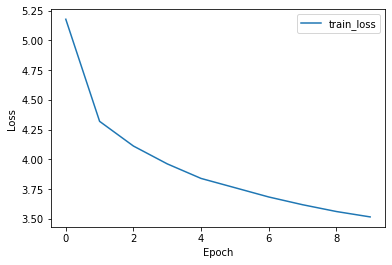

In [ ]:
import matplotlib.pyplot as plt

# Set up figure and axes
fig, ax = plt.subplots()

# Plot training and validation loss
ax.plot(loss_stats['train'], label="train_loss")


# Add a legend
ax.legend()

# Set x-axis label
ax.set_xlabel("Epoch")

# Set y-axis label
ax.set_ylabel("Loss")

# Show plot
plt.show()

In [ ]:
Model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(pretrained=False, num_classes=2)

checkPoint = torch.load("/content/drive/MyDrive/PALAI/wheat_detection_ckpt_SSD_MODEL.pth",
                        map_location=getDevice())

Model.load_state_dict(checkPoint['model_state_dict'])
Model.eval()
Model.to(getDevice())

In [ ]:
def show_output_with_bbox(img, bboxes, labels, scores):

    img_height = img.shape[0]
    img_width = img.shape[1]
    
    fig, ax = plt.subplots(figsize=(8,8))

    ax.imshow(img)

    for box, class_name, score in zip(bboxes, labels, scores):

        if score >= 0.0:

            class_name = class_dict[class_name]
            xmin, ymin, xmax, ymax = box
            xmin, ymin, width, height = [x for x in [xmin, ymin, (xmax-xmin), (ymax-ymin)]]
            rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(xmin, ymin, f"{class_name, np.round(score, 2)}", color='r', fontsize='large')

            # {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
    
    plt.show()


In [ ]:
class_dict = {
    0:"background",
    1:"1",
}

for image in glob("test/*"):
    img = cv2.imread(image)
    # img = cv2.resize(img, (300, 300))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
    img = img/255.0


    Model.eval()
    img_tensor_float = torch.tensor(img, dtype=torch.float32).permute(2,0,1).unsqueeze(dim=0).to(device)
    out = Model(img_tensor_float)

    keepIndex = torchvision.ops.nms(out[0]['boxes'], out[0]['scores'], iou_threshold=0.1)

    bboxTensors = out[0]['boxes'][keepIndex]
    labelsTensors = out[0]['labels'][keepIndex]
    scoresTensors = out[0]['scores'][keepIndex]


    boxes = bboxTensors.detach().cpu().numpy().astype(np.int)
    labels = labelsTensors.detach().cpu().numpy()
    scores = scoresTensors.detach().cpu().numpy()

    show_output_with_bbox(img, boxes, labels, scores)

# **USING VGG-16 AS BACK BONE :**

In [ ]:
SSD_VGG16_MODEL = torchvision.models.detection.ssd300_vgg16(pretrained=False, num_classes=2)

Downloading: "https://download.pytorch.org/models/vgg16_features-amdegroot-88682ab5.pth" to /root/.cache/torch/hub/checkpoints/vgg16_features-amdegroot-88682ab5.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
torch.cuda.empty_cache()

def getDevice():
    return torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device = getDevice()
device
if torch.cuda.is_available():
    SSD_VGG16_MODEL.cuda()

params = [p for p in SSD_VGG16_MODEL.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(params, lr=0.1, momentum=0.9, weight_decay=0.0005)
optimizer = torch.optim.Adam(params, lr=0.001,weight_decay=0.0005)
EPOCHS = 10

loss_stats = {
    'train': [],
    "epoch": []
}
# TRAINING
print("Begin training.")
for e in range(EPOCHS):
    print("Epoch Number is :",e)
    epoch_loss = []
    SSD_VGG16_MODEL.train()
    for i, data in tqdm(enumerate(train_data_loader)):
        # data of each batch
        images, targets = data
        # images, targets = images.cuda(), targets.cuda()
        optimizer.zero_grad()
         # copy data to cuda
        inputs = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # pass input to model
        loss_dict_train = SSD_VGG16_MODEL(inputs, targets)

        # loss
        losses_train = sum(loss for loss in loss_dict_train.values())
        epoch_loss.append(losses_train.item())

        # backprop
        losses_train.backward()

        # update weights
        optimizer.step()
        #------====------#
    
    # Epoch end - Training loss
    train_loss_epoch = np.mean(epoch_loss)
    loss_stats['train'].append(train_loss_epoch)
    loss_stats['epoch'].append(e)
    print(f'Epoch {e+0:03}: | Train Loss: {train_loss_epoch :.5f}')
    

#VALIDATION 
    print("\nBegin Validation.")   
    coco_evaluater = evaluate(SSD_VGG16_MODEL, valid_data_loader, device=device)
    print(coco_evaluater.coco_eval)

    if e > 6:
        if loss_stats['train'][-1] > (loss_stats['train'][-2] and loss_stats['train'][-3]):
            break
    torch.save({
            'epoch': e,
            'model_state_dict': SSD_VGG16_MODEL.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, "/content/drive/MyDrive/PALAI/wheat_detection_ckpt_SSD_MODEL_VGG_16.pth")
    
    

Begin training.
Epoch Number is : 0


607it [02:38,  3.83it/s]


Epoch 000: | Train Loss: 5.03428

Begin Validation.
creating index...
index created!
Test:  [  0/113]  eta: 0:01:34  model_time: 0.1144 (0.1144)  evaluator_time: 0.3090 (0.3090)  time: 0.8406  data: 0.3858  max mem: 972
Test:  [100/113]  eta: 0:00:04  model_time: 0.0775 (0.0779)  evaluator_time: 0.2196 (0.2455)  time: 0.3351  data: 0.0179  max mem: 972
Test:  [112/113]  eta: 0:00:00  model_time: 0.0770 (0.0776)  evaluator_time: 0.2131 (0.2437)  time: 0.3270  data: 0.0170  max mem: 972
Test: Total time: 0:00:40 (0.3547 s / it)
Averaged stats: model_time: 0.0770 (0.0776)  evaluator_time: 0.2131 (0.2437)
Accumulating evaluation results...
DONE (t=0.29s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.171
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.517
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.065
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Av

607it [02:34,  3.94it/s]


Epoch 001: | Train Loss: 3.39461

Begin Validation.
creating index...
index created!
Test:  [  0/113]  eta: 0:01:37  model_time: 0.0889 (0.0889)  evaluator_time: 0.3680 (0.3680)  time: 0.8670  data: 0.3902  max mem: 972
Test:  [100/113]  eta: 0:00:04  model_time: 0.0779 (0.0777)  evaluator_time: 0.2619 (0.2430)  time: 0.3751  data: 0.0174  max mem: 972
Test:  [112/113]  eta: 0:00:00  model_time: 0.0774 (0.0774)  evaluator_time: 0.1897 (0.2386)  time: 0.3168  data: 0.0166  max mem: 972
Test: Total time: 0:00:39 (0.3492 s / it)
Averaged stats: model_time: 0.0774 (0.0774)  evaluator_time: 0.1897 (0.2386)
Accumulating evaluation results...
DONE (t=0.30s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.284
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.702
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.166
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.009
 Av

607it [02:33,  3.97it/s]


Epoch 002: | Train Loss: 3.06644

Begin Validation.
creating index...
index created!
Test:  [  0/113]  eta: 0:01:27  model_time: 0.1183 (0.1183)  evaluator_time: 0.2595 (0.2595)  time: 0.7703  data: 0.3741  max mem: 972
Test:  [100/113]  eta: 0:00:04  model_time: 0.0775 (0.0780)  evaluator_time: 0.2518 (0.2390)  time: 0.3640  data: 0.0179  max mem: 972
Test:  [112/113]  eta: 0:00:00  model_time: 0.0766 (0.0776)  evaluator_time: 0.2250 (0.2416)  time: 0.3509  data: 0.0170  max mem: 972
Test: Total time: 0:00:39 (0.3518 s / it)
Averaged stats: model_time: 0.0766 (0.0776)  evaluator_time: 0.2250 (0.2416)
Accumulating evaluation results...
DONE (t=0.30s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.320
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.744
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.216
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.022
 Av

607it [02:28,  4.09it/s]


Epoch 003: | Train Loss: 2.85705

Begin Validation.
creating index...
index created!
Test:  [  0/113]  eta: 0:01:52  model_time: 0.0901 (0.0901)  evaluator_time: 0.4360 (0.4360)  time: 0.9999  data: 0.4493  max mem: 972
Test:  [100/113]  eta: 0:00:04  model_time: 0.0766 (0.0773)  evaluator_time: 0.2458 (0.2298)  time: 0.3752  data: 0.0175  max mem: 972
Test:  [112/113]  eta: 0:00:00  model_time: 0.0764 (0.0770)  evaluator_time: 0.2270 (0.2274)  time: 0.3380  data: 0.0172  max mem: 972
Test: Total time: 0:00:38 (0.3378 s / it)
Averaged stats: model_time: 0.0764 (0.0770)  evaluator_time: 0.2270 (0.2274)
Accumulating evaluation results...
DONE (t=0.29s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.356
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.782
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.272
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.051
 Av

607it [02:33,  3.96it/s]


Epoch 004: | Train Loss: 2.71817

Begin Validation.
creating index...
index created!
Test:  [  0/113]  eta: 0:01:36  model_time: 0.0848 (0.0848)  evaluator_time: 0.3424 (0.3424)  time: 0.8553  data: 0.4034  max mem: 972
Test:  [100/113]  eta: 0:00:04  model_time: 0.0764 (0.0773)  evaluator_time: 0.1915 (0.2118)  time: 0.3113  data: 0.0179  max mem: 972
Test:  [112/113]  eta: 0:00:00  model_time: 0.0763 (0.0770)  evaluator_time: 0.1981 (0.2131)  time: 0.3122  data: 0.0166  max mem: 972
Test: Total time: 0:00:36 (0.3230 s / it)
Averaged stats: model_time: 0.0763 (0.0770)  evaluator_time: 0.1981 (0.2131)
Accumulating evaluation results...
DONE (t=0.25s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.372
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.802
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.288
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.054
 Av

607it [02:28,  4.08it/s]


Epoch 005: | Train Loss: 2.63340

Begin Validation.
creating index...
index created!
Test:  [  0/113]  eta: 0:01:28  model_time: 0.0879 (0.0879)  evaluator_time: 0.2507 (0.2507)  time: 0.7802  data: 0.4238  max mem: 972
Test:  [100/113]  eta: 0:00:04  model_time: 0.0765 (0.0771)  evaluator_time: 0.2052 (0.2107)  time: 0.3127  data: 0.0181  max mem: 972
Test:  [112/113]  eta: 0:00:00  model_time: 0.0763 (0.0768)  evaluator_time: 0.1892 (0.2077)  time: 0.2978  data: 0.0177  max mem: 972
Test: Total time: 0:00:35 (0.3176 s / it)
Averaged stats: model_time: 0.0763 (0.0768)  evaluator_time: 0.1892 (0.2077)
Accumulating evaluation results...
DONE (t=0.26s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.383
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.818
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.307
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.072
 Av

607it [02:32,  3.98it/s]


Epoch 006: | Train Loss: 2.56462

Begin Validation.
creating index...
index created!
Test:  [  0/113]  eta: 0:01:29  model_time: 0.0851 (0.0851)  evaluator_time: 0.2933 (0.2933)  time: 0.7932  data: 0.3856  max mem: 972
Test:  [100/113]  eta: 0:00:04  model_time: 0.0768 (0.0775)  evaluator_time: 0.1820 (0.2111)  time: 0.2893  data: 0.0175  max mem: 972
Test:  [112/113]  eta: 0:00:00  model_time: 0.0766 (0.0772)  evaluator_time: 0.1890 (0.2116)  time: 0.3038  data: 0.0172  max mem: 972
Test: Total time: 0:00:36 (0.3224 s / it)
Averaged stats: model_time: 0.0766 (0.0772)  evaluator_time: 0.1890 (0.2116)
Accumulating evaluation results...
DONE (t=0.26s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.377
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.816
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.289
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.071
 Av

607it [02:39,  3.79it/s]


Epoch 007: | Train Loss: 2.52191

Begin Validation.
creating index...
index created!
Test:  [  0/113]  eta: 0:01:34  model_time: 0.0900 (0.0900)  evaluator_time: 0.2976 (0.2976)  time: 0.8362  data: 0.4329  max mem: 972
Test:  [100/113]  eta: 0:00:04  model_time: 0.0773 (0.0771)  evaluator_time: 0.2153 (0.2100)  time: 0.3308  data: 0.0184  max mem: 972
Test:  [112/113]  eta: 0:00:00  model_time: 0.0770 (0.0769)  evaluator_time: 0.1881 (0.2074)  time: 0.3014  data: 0.0170  max mem: 972
Test: Total time: 0:00:35 (0.3178 s / it)
Averaged stats: model_time: 0.0770 (0.0769)  evaluator_time: 0.1881 (0.2074)
Accumulating evaluation results...
DONE (t=0.26s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.379
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.825
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.294
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.063
 Av

607it [02:28,  4.08it/s]


Epoch 008: | Train Loss: 2.48751

Begin Validation.
creating index...
index created!
Test:  [  0/113]  eta: 0:01:37  model_time: 0.0930 (0.0930)  evaluator_time: 0.3396 (0.3396)  time: 0.8614  data: 0.4018  max mem: 972
Test:  [100/113]  eta: 0:00:04  model_time: 0.0768 (0.0776)  evaluator_time: 0.2094 (0.2096)  time: 0.3275  data: 0.0176  max mem: 972
Test:  [112/113]  eta: 0:00:00  model_time: 0.0770 (0.0771)  evaluator_time: 0.2310 (0.2126)  time: 0.3376  data: 0.0173  max mem: 972
Test: Total time: 0:00:36 (0.3226 s / it)
Averaged stats: model_time: 0.0770 (0.0771)  evaluator_time: 0.2310 (0.2126)
Accumulating evaluation results...
DONE (t=0.28s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.399
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.831
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.328
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.076
 Av

607it [02:32,  3.98it/s]


Epoch 009: | Train Loss: 2.45548

Begin Validation.
creating index...
index created!
Test:  [  0/113]  eta: 0:01:32  model_time: 0.1019 (0.1019)  evaluator_time: 0.2712 (0.2712)  time: 0.8167  data: 0.4175  max mem: 972
Test:  [100/113]  eta: 0:00:04  model_time: 0.0773 (0.0777)  evaluator_time: 0.1823 (0.2098)  time: 0.3244  data: 0.0170  max mem: 972
Test:  [112/113]  eta: 0:00:00  model_time: 0.0770 (0.0775)  evaluator_time: 0.1880 (0.2070)  time: 0.3178  data: 0.0173  max mem: 972
Test: Total time: 0:00:35 (0.3178 s / it)
Averaged stats: model_time: 0.0770 (0.0775)  evaluator_time: 0.1880 (0.2070)
Accumulating evaluation results...
DONE (t=0.26s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.405
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.833
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.338
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.070
 Av

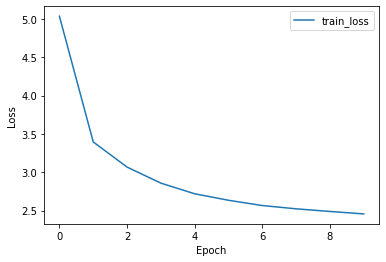

In [ ]:
import matplotlib.pyplot as plt

# Set up figure and axes
fig, ax = plt.subplots()

# Plot training and validation loss
ax.plot(loss_stats['train'], label="train_loss")


# Add a legend
ax.legend()

# Set x-axis label
ax.set_xlabel("Epoch")

# Set y-axis label
ax.set_ylabel("Loss")

# Show plot
plt.show()

In [ ]:
def getDevice():
    return torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device = getDevice()
Model_Vgg16 = torchvision.models.detection.ssd300_vgg16(pretrained=False, num_classes=2)

checkPoint = torch.load("/content/drive/MyDrive/PALAI/wheat_detection_ckpt_SSD_MODEL_VGG_16.pth",
                        map_location=getDevice())

Model_Vgg16.load_state_dict(checkPoint['model_state_dict'])
Model_Vgg16.eval()
Model_Vgg16.to(getDevice())


In [ ]:
def show_output_with_bbox(img, bboxes, labels, scores):

    img_height = img.shape[0]
    img_width = img.shape[1]
    
    fig, ax = plt.subplots(figsize=(8,8))

    ax.imshow(img)

    for box, class_name, score in zip(bboxes, labels, scores):

        if score >= 0.0:

            class_name = class_dict[class_name]
            xmin, ymin, xmax, ymax = box
            xmin, ymin, width, height = [x for x in [xmin, ymin, (xmax-xmin), (ymax-ymin)]]
            rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(xmin, ymin, f"{class_name, np.round(score, 2)}", color='r', fontsize='large')

            # {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
    
    plt.show()

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches

class_dict = {
    0:"background",
    1:"1",
}

for image in glob("test/*"):
    img = cv2.imread(image)
    # img = cv2.resize(img, (300, 300))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
    img = img/255.0


    Model_Vgg16.eval()
    img_tensor_float = torch.tensor(img, dtype=torch.float32).permute(2,0,1).unsqueeze(dim=0).to(device)
    out = Model_Vgg16(img_tensor_float)

    keepIndex = torchvision.ops.nms(out[0]['boxes'], out[0]['scores'], iou_threshold=0.1)

    bboxTensors = out[0]['boxes'][keepIndex]
    labelsTensors = out[0]['labels'][keepIndex]
    scoresTensors = out[0]['scores'][keepIndex]


    boxes = bboxTensors.detach().cpu().numpy().astype(np.int)
    labels = labelsTensors.detach().cpu().numpy()
    scores = scoresTensors.detach().cpu().numpy()

    show_output_with_bbox(img, boxes, labels, scores)

# **Observations Between Two Models:**



*   MobileNet back bone worked well with SGD 
*   VGG-16 back bone worked well with Adam



# **Faster RCNN (MOBILENET_320):**

In [ ]:
def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes) 

    return model

FASTER_RCNN_MOBILENET_MODEL = get_object_detection_model(2)

In [ ]:
torch.cuda.empty_cache()

def getDevice():
    return torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device = getDevice()
device
if torch.cuda.is_available():
    FASTER_RCNN_MOBILENET_MODEL.cuda()

params = [p for p in FASTER_RCNN_MOBILENET_MODEL.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.0005)

EPOCHS = 10

loss_stats = {
    'train': [],
    "epoch": []
}
# TRAINING
print("Begin training.")
for e in range(EPOCHS):
    print("Epoch Number is :",e)
    epoch_loss = []
    FASTER_RCNN_MOBILENET_MODEL.train()
    for i, data in tqdm(enumerate(train_data_loader)):
        # data of each batch
        images, targets = data
        # images, targets = images.cuda(), targets.cuda()
        optimizer.zero_grad()
         # copy data to cuda
        inputs = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # pass input to model
        loss_dict_train = FASTER_RCNN_MOBILENET_MODEL(inputs, targets)

        # loss
        losses_train = sum(loss for loss in loss_dict_train.values())
        epoch_loss.append(losses_train.item())

        # backprop
        losses_train.backward()

        # update weights
        optimizer.step()
        #------====------#
    
    # Epoch end - Training loss
    train_loss_epoch = np.mean(epoch_loss)
    loss_stats['train'].append(train_loss_epoch)
    loss_stats['epoch'].append(e)
    print(f'Epoch {e+0:03}: | Train Loss: {train_loss_epoch :.5f}')
    

#VALIDATION 
    print("\nBegin Validation.")   
    coco_evaluater = evaluate(FASTER_RCNN_MOBILENET_MODEL, valid_data_loader, device=device)
    print(coco_evaluater.coco_eval)

    if e > 6:
        if loss_stats['train'][-1] > (loss_stats['train'][-2] and loss_stats['train'][-3]):
            break
    torch.save({
            'epoch': e,
            'model_state_dict': FASTER_RCNN_MOBILENET_MODEL.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, "/content/drive/MyDrive/PALAI/wheat_detection_ckpt_FASTER_RCNN_MODEL_MOBILE_NET.pth")

Begin training.
Epoch Number is : 0


607it [02:26,  4.13it/s]


Epoch 000: | Train Loss: 1.33091

Begin Validation.
creating index...
index created!
Test:  [  0/113]  eta: 0:01:12  model_time: 0.1134 (0.1134)  evaluator_time: 0.1426 (0.1426)  time: 0.6450  data: 0.3677  max mem: 870
Test:  [100/113]  eta: 0:00:03  model_time: 0.0409 (0.0422)  evaluator_time: 0.1861 (0.1724)  time: 0.2595  data: 0.0184  max mem: 870
Test:  [112/113]  eta: 0:00:00  model_time: 0.0414 (0.0417)  evaluator_time: 0.1980 (0.1742)  time: 0.2639  data: 0.0176  max mem: 870
Test: Total time: 0:00:28 (0.2484 s / it)
Averaged stats: model_time: 0.0414 (0.0417)  evaluator_time: 0.1980 (0.1742)
Accumulating evaluation results...
DONE (t=0.19s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.093
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.309
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Av

607it [02:39,  3.80it/s]


Epoch 001: | Train Loss: 1.28752

Begin Validation.
creating index...
index created!
Test:  [  0/113]  eta: 0:01:20  model_time: 0.0495 (0.0495)  evaluator_time: 0.2678 (0.2678)  time: 0.7156  data: 0.3869  max mem: 870
Test:  [100/113]  eta: 0:00:03  model_time: 0.0420 (0.0456)  evaluator_time: 0.1676 (0.1968)  time: 0.2340  data: 0.0180  max mem: 870
Test:  [112/113]  eta: 0:00:00  model_time: 0.0412 (0.0447)  evaluator_time: 0.1504 (0.1934)  time: 0.2302  data: 0.0165  max mem: 870
Test: Total time: 0:00:30 (0.2727 s / it)
Averaged stats: model_time: 0.0412 (0.0447)  evaluator_time: 0.1504 (0.1934)
Accumulating evaluation results...
DONE (t=0.19s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.106
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.342
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.034
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.007
 Av

607it [02:51,  3.53it/s]


Epoch 002: | Train Loss: 1.26973

Begin Validation.
creating index...
index created!
Test:  [  0/113]  eta: 0:01:23  model_time: 0.0811 (0.0811)  evaluator_time: 0.2417 (0.2417)  time: 0.7418  data: 0.3893  max mem: 870
Test:  [100/113]  eta: 0:00:03  model_time: 0.0408 (0.0422)  evaluator_time: 0.1606 (0.1771)  time: 0.2438  data: 0.0182  max mem: 870
Test:  [112/113]  eta: 0:00:00  model_time: 0.0400 (0.0416)  evaluator_time: 0.1584 (0.1764)  time: 0.2398  data: 0.0167  max mem: 870
Test: Total time: 0:00:28 (0.2508 s / it)
Averaged stats: model_time: 0.0400 (0.0416)  evaluator_time: 0.1584 (0.1764)
Accumulating evaluation results...
DONE (t=0.18s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.122
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.377
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.046
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.004
 Av

607it [02:29,  4.05it/s]


Epoch 003: | Train Loss: 1.26329

Begin Validation.
creating index...
index created!
Test:  [  0/113]  eta: 0:01:25  model_time: 0.1007 (0.1007)  evaluator_time: 0.2528 (0.2528)  time: 0.7610  data: 0.3885  max mem: 870
Test:  [100/113]  eta: 0:00:03  model_time: 0.0415 (0.0425)  evaluator_time: 0.1783 (0.1777)  time: 0.2517  data: 0.0181  max mem: 870
Test:  [112/113]  eta: 0:00:00  model_time: 0.0414 (0.0420)  evaluator_time: 0.1553 (0.1758)  time: 0.2377  data: 0.0176  max mem: 870
Test: Total time: 0:00:28 (0.2515 s / it)
Averaged stats: model_time: 0.0414 (0.0420)  evaluator_time: 0.1553 (0.1758)
Accumulating evaluation results...
DONE (t=0.18s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.126
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.395
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.044
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Av

607it [02:25,  4.18it/s]


Epoch 004: | Train Loss: 1.25162

Begin Validation.
creating index...
index created!
Test:  [  0/113]  eta: 0:02:28  model_time: 0.1967 (0.1967)  evaluator_time: 0.6102 (0.6102)  time: 1.3113  data: 0.4812  max mem: 870
Test:  [100/113]  eta: 0:00:03  model_time: 0.0408 (0.0445)  evaluator_time: 0.1747 (0.1926)  time: 0.2509  data: 0.0186  max mem: 870
Test:  [112/113]  eta: 0:00:00  model_time: 0.0409 (0.0438)  evaluator_time: 0.1614 (0.1887)  time: 0.2252  data: 0.0175  max mem: 870
Test: Total time: 0:00:30 (0.2679 s / it)
Averaged stats: model_time: 0.0409 (0.0438)  evaluator_time: 0.1614 (0.1887)
Accumulating evaluation results...
DONE (t=0.18s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.140
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.416
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.055
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Av

607it [02:22,  4.25it/s]


Epoch 005: | Train Loss: 1.23634

Begin Validation.
creating index...
index created!
Test:  [  0/113]  eta: 0:01:21  model_time: 0.1045 (0.1045)  evaluator_time: 0.2218 (0.2218)  time: 0.7172  data: 0.3770  max mem: 870
Test:  [100/113]  eta: 0:00:03  model_time: 0.0413 (0.0429)  evaluator_time: 0.1663 (0.1776)  time: 0.2354  data: 0.0178  max mem: 870
Test:  [112/113]  eta: 0:00:00  model_time: 0.0405 (0.0423)  evaluator_time: 0.1535 (0.1743)  time: 0.2196  data: 0.0174  max mem: 870
Test: Total time: 0:00:28 (0.2496 s / it)
Averaged stats: model_time: 0.0405 (0.0423)  evaluator_time: 0.1535 (0.1743)
Accumulating evaluation results...
DONE (t=0.18s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.145
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.422
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.062
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Av

607it [02:26,  4.15it/s]


Epoch 006: | Train Loss: 1.22843

Begin Validation.
creating index...
index created!
Test:  [  0/113]  eta: 0:01:08  model_time: 0.0541 (0.0541)  evaluator_time: 0.1529 (0.1529)  time: 0.6067  data: 0.3880  max mem: 870
Test:  [100/113]  eta: 0:00:03  model_time: 0.0413 (0.0417)  evaluator_time: 0.1735 (0.1834)  time: 0.2467  data: 0.0177  max mem: 870
Test:  [112/113]  eta: 0:00:00  model_time: 0.0414 (0.0413)  evaluator_time: 0.1497 (0.1818)  time: 0.2347  data: 0.0173  max mem: 870
Test: Total time: 0:00:28 (0.2564 s / it)
Averaged stats: model_time: 0.0414 (0.0413)  evaluator_time: 0.1497 (0.1818)
Accumulating evaluation results...
DONE (t=0.19s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.135
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.415
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.048
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Av

607it [02:25,  4.16it/s]


Epoch 007: | Train Loss: 1.22331

Begin Validation.
creating index...
index created!
Test:  [  0/113]  eta: 0:01:22  model_time: 0.0851 (0.0851)  evaluator_time: 0.2325 (0.2325)  time: 0.7344  data: 0.3901  max mem: 870
Test:  [100/113]  eta: 0:00:03  model_time: 0.0418 (0.0426)  evaluator_time: 0.1821 (0.1762)  time: 0.2526  data: 0.0179  max mem: 870
Test:  [112/113]  eta: 0:00:00  model_time: 0.0409 (0.0421)  evaluator_time: 0.1663 (0.1733)  time: 0.2294  data: 0.0178  max mem: 870
Test: Total time: 0:00:28 (0.2487 s / it)
Averaged stats: model_time: 0.0409 (0.0421)  evaluator_time: 0.1663 (0.1733)
Accumulating evaluation results...
DONE (t=0.18s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.163
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.463
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.070
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.003
 Av

607it [02:25,  4.17it/s]


Epoch 008: | Train Loss: 1.21721

Begin Validation.
creating index...
index created!
Test:  [  0/113]  eta: 0:01:17  model_time: 0.1122 (0.1122)  evaluator_time: 0.1409 (0.1409)  time: 0.6824  data: 0.4097  max mem: 870
Test:  [100/113]  eta: 0:00:03  model_time: 0.0413 (0.0427)  evaluator_time: 0.1779 (0.1843)  time: 0.2593  data: 0.0183  max mem: 870
Test:  [112/113]  eta: 0:00:00  model_time: 0.0407 (0.0422)  evaluator_time: 0.1908 (0.1823)  time: 0.2464  data: 0.0184  max mem: 870
Test: Total time: 0:00:29 (0.2581 s / it)
Averaged stats: model_time: 0.0407 (0.0422)  evaluator_time: 0.1908 (0.1823)
Accumulating evaluation results...
DONE (t=0.20s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.136
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.428
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.044
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Av

607it [02:25,  4.16it/s]


Epoch 009: | Train Loss: 1.21216

Begin Validation.
creating index...
index created!
Test:  [  0/113]  eta: 0:01:19  model_time: 0.1121 (0.1121)  evaluator_time: 0.2131 (0.2131)  time: 0.7033  data: 0.3601  max mem: 870
Test:  [100/113]  eta: 0:00:03  model_time: 0.0408 (0.0425)  evaluator_time: 0.1730 (0.1768)  time: 0.2454  data: 0.0180  max mem: 870
Test:  [112/113]  eta: 0:00:00  model_time: 0.0406 (0.0419)  evaluator_time: 0.1537 (0.1751)  time: 0.2278  data: 0.0164  max mem: 870
Test: Total time: 0:00:28 (0.2490 s / it)
Averaged stats: model_time: 0.0406 (0.0419)  evaluator_time: 0.1537 (0.1751)
Accumulating evaluation results...
DONE (t=0.19s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.173
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.480
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.079
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Av

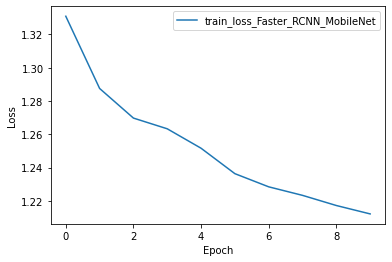

In [ ]:
import matplotlib.pyplot as plt

# Set up figure and axes
fig, ax = plt.subplots()

# Plot training and validation loss
ax.plot(loss_stats['train'], label="train_loss_Faster_RCNN_MobileNet")


# Add a legend
ax.legend()

# Set x-axis label
ax.set_xlabel("Epoch")

# Set y-axis label
ax.set_ylabel("Loss")

# Show plot
plt.show()

In [ ]:
def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes) 

    return model

Model_Faster_RCNN_MobileNet = get_object_detection_model(2)

In [ ]:
def getDevice():
    return torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device = getDevice()


checkPoint = torch.load("/content/drive/MyDrive/PALAI/wheat_detection_ckpt_FASTER_RCNN_MODEL_MOBILE_NET.pth",
                        map_location=getDevice())

Model_Faster_RCNN_MobileNet.load_state_dict(checkPoint['model_state_dict'])
Model_Faster_RCNN_MobileNet.eval()
Model_Faster_RCNN_MobileNet.to(getDevice())


In [ ]:
def show_output_with_bbox(img, bboxes, labels, scores):

    img_height = img.shape[0]
    img_width = img.shape[1]
    
    fig, ax = plt.subplots(figsize=(8,8))

    ax.imshow(img)

    for box, class_name, score in zip(bboxes, labels, scores):

        if score >= 0.0:

            class_name = class_dict[class_name]
            xmin, ymin, xmax, ymax = box
            xmin, ymin, width, height = [x for x in [xmin, ymin, (xmax-xmin), (ymax-ymin)]]
            rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(xmin, ymin, f"{class_name, np.round(score, 2)}", color='r', fontsize='large')

            # {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
    
    plt.show()

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches

class_dict = {
    0:"background",
    1:"1",
}

for image in glob("test/*"):
    img = cv2.imread(image)
    # img = cv2.resize(img, (300, 300))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
    img = img/255.0


    Model_Faster_RCNN_MobileNet.eval()
    img_tensor_float = torch.tensor(img, dtype=torch.float32).permute(2,0,1).unsqueeze(dim=0).to(device)
    out = Model_Faster_RCNN_MobileNet(img_tensor_float)

    keepIndex = torchvision.ops.nms(out[0]['boxes'], out[0]['scores'], iou_threshold=0.1)

    bboxTensors = out[0]['boxes'][keepIndex]
    labelsTensors = out[0]['labels'][keepIndex]
    scoresTensors = out[0]['scores'][keepIndex]


    boxes = bboxTensors.detach().cpu().numpy().astype(np.int)
    labels = labelsTensors.detach().cpu().numpy()
    scores = scoresTensors.detach().cpu().numpy()

    show_output_with_bbox(img, boxes, labels, scores)

# **Faster RCNN (RESNET_50):**

In [ ]:
def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes) 

    return model

FASTER_RCNN_RESNET_50_MODEL = get_object_detection_model(2)

In [ ]:
torch.cuda.empty_cache()

def getDevice():
    return torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device = getDevice()
device
if torch.cuda.is_available():
    FASTER_RCNN_RESNET_50_MODEL.cuda()

params = [p for p in FASTER_RCNN_RESNET_50_MODEL.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.0005)

EPOCHS = 10

loss_stats = {
    'train': [],
    "epoch": []
}
# TRAINING
print("Begin training.")
for e in range(EPOCHS):
    print("Epoch Number is :",e)
    epoch_loss = []
    FASTER_RCNN_RESNET_50_MODEL.train()
    for i, data in tqdm(enumerate(train_data_loader)):
        # data of each batch
        images, targets = data
        # images, targets = images.cuda(), targets.cuda()
        optimizer.zero_grad()
         # copy data to cuda
        inputs = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # pass input to model
        loss_dict_train = FASTER_RCNN_RESNET_50_MODEL(inputs, targets)

        # loss
        losses_train = sum(loss for loss in loss_dict_train.values())
        epoch_loss.append(losses_train.item())

        # backprop
        losses_train.backward()

        # update weights
        optimizer.step()
        #------====------#
    
    # Epoch end - Training loss
    train_loss_epoch = np.mean(epoch_loss)
    loss_stats['train'].append(train_loss_epoch)
    loss_stats['epoch'].append(e)
    print(f'Epoch {e+0:03}: | Train Loss: {train_loss_epoch :.5f}')
    

#VALIDATION 
    print("\nBegin Validation.")   
    coco_evaluater = evaluate(FASTER_RCNN_RESNET_50_MODEL, valid_data_loader, device=device)
    print(coco_evaluater.coco_eval)

    if e > 6:
        if loss_stats['train'][-1] > (loss_stats['train'][-2] and loss_stats['train'][-3]):
            break
    torch.save({
            'epoch': e,
            'model_state_dict': FASTER_RCNN_RESNET_50_MODEL.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, "/content/drive/MyDrive/PALAI/wheat_detection_ckpt_FASTER_RCNN_MODEL_RESNET_50.pth")

Begin training.
Epoch Number is : 0


607it [16:40,  1.65s/it]


Epoch 000: | Train Loss: 0.84857

Begin Validation.
creating index...
index created!
Test:  [  0/113]  eta: 0:01:53  model_time: 0.4442 (0.4442)  evaluator_time: 0.1782 (0.1782)  time: 1.0003  data: 0.3663  max mem: 9136
Test:  [100/113]  eta: 0:00:07  model_time: 0.3645 (0.3647)  evaluator_time: 0.1752 (0.2049)  time: 0.5985  data: 0.0170  max mem: 9136
Test:  [112/113]  eta: 0:00:00  model_time: 0.3637 (0.3634)  evaluator_time: 0.1681 (0.2017)  time: 0.5556  data: 0.0162  max mem: 9136
Test: Total time: 0:01:07 (0.5974 s / it)
Averaged stats: model_time: 0.3637 (0.3634)  evaluator_time: 0.1681 (0.2017)
Accumulating evaluation results...
DONE (t=0.24s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.472
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.906
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.442
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.121


607it [16:34,  1.64s/it]


Epoch 001: | Train Loss: 0.72290

Begin Validation.
creating index...
index created!
Test:  [  0/113]  eta: 0:02:12  model_time: 0.4224 (0.4224)  evaluator_time: 0.3506 (0.3506)  time: 1.1696  data: 0.3773  max mem: 9136
Test:  [100/113]  eta: 0:00:07  model_time: 0.3608 (0.3643)  evaluator_time: 0.1573 (0.1900)  time: 0.5601  data: 0.0172  max mem: 9136
Test:  [112/113]  eta: 0:00:00  model_time: 0.3597 (0.3628)  evaluator_time: 0.1752 (0.1906)  time: 0.5655  data: 0.0165  max mem: 9136
Test: Total time: 0:01:06 (0.5866 s / it)
Averaged stats: model_time: 0.3597 (0.3628)  evaluator_time: 0.1752 (0.1906)
Accumulating evaluation results...
DONE (t=0.23s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.483
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.909
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.461
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.144


607it [16:35,  1.64s/it]


Epoch 002: | Train Loss: 0.68085

Begin Validation.
creating index...
index created!
Test:  [  0/113]  eta: 0:01:50  model_time: 0.4303 (0.4303)  evaluator_time: 0.1388 (0.1388)  time: 0.9797  data: 0.3839  max mem: 9136
Test:  [100/113]  eta: 0:00:07  model_time: 0.3627 (0.3644)  evaluator_time: 0.2005 (0.1835)  time: 0.5964  data: 0.0179  max mem: 9136
Test:  [112/113]  eta: 0:00:00  model_time: 0.3615 (0.3631)  evaluator_time: 0.1962 (0.1857)  time: 0.5887  data: 0.0157  max mem: 9136
Test: Total time: 0:01:05 (0.5815 s / it)
Averaged stats: model_time: 0.3615 (0.3631)  evaluator_time: 0.1962 (0.1857)
Accumulating evaluation results...
DONE (t=0.23s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.483
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.912
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.456
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.140


607it [16:36,  1.64s/it]


Epoch 003: | Train Loss: 0.65037

Begin Validation.
creating index...
index created!
Test:  [  0/113]  eta: 0:01:59  model_time: 0.4359 (0.4359)  evaluator_time: 0.2412 (0.2412)  time: 1.0616  data: 0.3658  max mem: 9136
Test:  [100/113]  eta: 0:00:07  model_time: 0.3631 (0.3642)  evaluator_time: 0.1316 (0.1751)  time: 0.5581  data: 0.0167  max mem: 9136
Test:  [112/113]  eta: 0:00:00  model_time: 0.3610 (0.3628)  evaluator_time: 0.1615 (0.1763)  time: 0.5649  data: 0.0160  max mem: 9136
Test: Total time: 0:01:04 (0.5709 s / it)
Averaged stats: model_time: 0.3610 (0.3628)  evaluator_time: 0.1615 (0.1763)
Accumulating evaluation results...
DONE (t=0.22s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.486
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.909
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.468
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.155


607it [16:34,  1.64s/it]


Epoch 004: | Train Loss: 0.62525

Begin Validation.
creating index...
index created!
Test:  [  0/113]  eta: 0:02:00  model_time: 0.4374 (0.4374)  evaluator_time: 0.2310 (0.2310)  time: 1.0645  data: 0.3727  max mem: 9136
Test:  [100/113]  eta: 0:00:07  model_time: 0.3661 (0.3662)  evaluator_time: 0.1204 (0.1721)  time: 0.5229  data: 0.0162  max mem: 9136
Test:  [112/113]  eta: 0:00:00  model_time: 0.3639 (0.3647)  evaluator_time: 0.1255 (0.1725)  time: 0.5445  data: 0.0159  max mem: 9136
Test: Total time: 0:01:04 (0.5687 s / it)
Averaged stats: model_time: 0.3639 (0.3647)  evaluator_time: 0.1255 (0.1725)
Accumulating evaluation results...
DONE (t=0.23s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.483
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.911
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.465
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.119


607it [16:35,  1.64s/it]


Epoch 005: | Train Loss: 0.60845

Begin Validation.
creating index...
index created!
Test:  [  0/113]  eta: 0:01:57  model_time: 0.4250 (0.4250)  evaluator_time: 0.1942 (0.1942)  time: 1.0392  data: 0.3997  max mem: 9136
Test:  [100/113]  eta: 0:00:07  model_time: 0.3639 (0.3653)  evaluator_time: 0.1609 (0.1686)  time: 0.5594  data: 0.0163  max mem: 9136
Test:  [112/113]  eta: 0:00:00  model_time: 0.3625 (0.3639)  evaluator_time: 0.1596 (0.1692)  time: 0.5467  data: 0.0161  max mem: 9136
Test: Total time: 0:01:03 (0.5649 s / it)
Averaged stats: model_time: 0.3625 (0.3639)  evaluator_time: 0.1596 (0.1692)
Accumulating evaluation results...
DONE (t=0.22s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.478
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.903
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.452
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.122


607it [16:35,  1.64s/it]


Epoch 006: | Train Loss: 0.59198

Begin Validation.
creating index...
index created!
Test:  [  0/113]  eta: 0:01:36  model_time: 0.4228 (0.4228)  evaluator_time: 0.0500 (0.0500)  time: 0.8520  data: 0.3583  max mem: 9136
Test:  [100/113]  eta: 0:00:07  model_time: 0.3677 (0.3664)  evaluator_time: 0.1701 (0.1697)  time: 0.5702  data: 0.0166  max mem: 9136
Test:  [112/113]  eta: 0:00:00  model_time: 0.3653 (0.3651)  evaluator_time: 0.1696 (0.1708)  time: 0.5728  data: 0.0161  max mem: 9136
Test: Total time: 0:01:04 (0.5678 s / it)
Averaged stats: model_time: 0.3653 (0.3651)  evaluator_time: 0.1696 (0.1708)
Accumulating evaluation results...
DONE (t=0.21s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.481
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.910
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.456
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.144


607it [16:35,  1.64s/it]


Epoch 007: | Train Loss: 0.57519

Begin Validation.
creating index...
index created!
Test:  [  0/113]  eta: 0:01:52  model_time: 0.4377 (0.4377)  evaluator_time: 0.1384 (0.1384)  time: 0.9989  data: 0.3944  max mem: 9136
Test:  [100/113]  eta: 0:00:07  model_time: 0.3642 (0.3656)  evaluator_time: 0.1819 (0.1740)  time: 0.5767  data: 0.0172  max mem: 9136
Test:  [112/113]  eta: 0:00:00  model_time: 0.3632 (0.3643)  evaluator_time: 0.1426 (0.1726)  time: 0.5403  data: 0.0166  max mem: 9136
Test: Total time: 0:01:04 (0.5690 s / it)
Averaged stats: model_time: 0.3632 (0.3643)  evaluator_time: 0.1426 (0.1726)
Accumulating evaluation results...
DONE (t=0.22s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.477
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.908
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.449
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.126


607it [16:35,  1.64s/it]


Epoch 008: | Train Loss: 0.55981

Begin Validation.
creating index...
index created!
Test:  [  0/113]  eta: 0:01:54  model_time: 0.4515 (0.4515)  evaluator_time: 0.1775 (0.1775)  time: 1.0118  data: 0.3639  max mem: 9136
Test:  [100/113]  eta: 0:00:07  model_time: 0.3659 (0.3666)  evaluator_time: 0.1313 (0.1726)  time: 0.5413  data: 0.0172  max mem: 9136
Test:  [112/113]  eta: 0:00:00  model_time: 0.3639 (0.3653)  evaluator_time: 0.1753 (0.1721)  time: 0.5484  data: 0.0158  max mem: 9136
Test: Total time: 0:01:04 (0.5693 s / it)
Averaged stats: model_time: 0.3639 (0.3653)  evaluator_time: 0.1753 (0.1721)
Accumulating evaluation results...
DONE (t=0.22s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.471
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.900
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.444
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.141


607it [16:34,  1.64s/it]


Epoch 009: | Train Loss: 0.54865

Begin Validation.
creating index...
index created!
Test:  [  0/113]  eta: 0:01:43  model_time: 0.4150 (0.4150)  evaluator_time: 0.1111 (0.1111)  time: 0.9174  data: 0.3726  max mem: 9136
Test:  [100/113]  eta: 0:00:07  model_time: 0.3673 (0.3667)  evaluator_time: 0.1590 (0.1697)  time: 0.5743  data: 0.0175  max mem: 9136
Test:  [112/113]  eta: 0:00:00  model_time: 0.3651 (0.3653)  evaluator_time: 0.1319 (0.1693)  time: 0.5490  data: 0.0165  max mem: 9136
Test: Total time: 0:01:04 (0.5666 s / it)
Averaged stats: model_time: 0.3651 (0.3653)  evaluator_time: 0.1319 (0.1693)
Accumulating evaluation results...
DONE (t=0.22s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.480
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.901
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.464
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.170


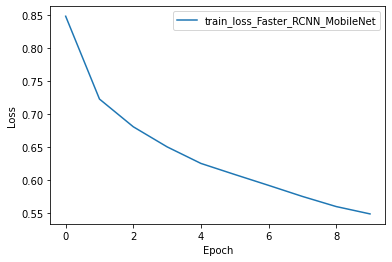

In [ ]:
import matplotlib.pyplot as plt

# Set up figure and axes
fig, ax = plt.subplots()

# Plot training and validation loss
ax.plot(loss_stats['train'], label="train_loss_Faster_RCNN_MobileNet")


# Add a legend
ax.legend()

# Set x-axis label
ax.set_xlabel("Epoch")

# Set y-axis label
ax.set_ylabel("Loss")

# Show plot
plt.show()

In [ ]:
def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes) 

    return model

Model_Faster_RCNN_ResNet50 = get_object_detection_model(2)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth


  0%|          | 0.00/167M [00:00<?, ?B/s]

In [ ]:
def getDevice():
    return torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device = getDevice()


checkPoint = torch.load("/content/drive/MyDrive/PALAI/wheat_detection_ckpt_FASTER_RCNN_MODEL_RESNET_50.pth",
                        map_location=getDevice())

Model_Faster_RCNN_ResNet50.load_state_dict(checkPoint['model_state_dict'])
Model_Faster_RCNN_ResNet50.eval()
Model_Faster_RCNN_ResNet50.to(getDevice())


In [ ]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches

class_dict = {
    0:"background",
    1:"1",
}

for image in glob("test/*"):
    img = cv2.imread(image)
    # img = cv2.resize(img, (300, 300))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
    img = img/255.0


    Model_Faster_RCNN_ResNet50.eval()
    img_tensor_float = torch.tensor(img, dtype=torch.float32).permute(2,0,1).unsqueeze(dim=0).to(device)
    out = Model_Faster_RCNN_ResNet50(img_tensor_float)

    keepIndex = torchvision.ops.nms(out[0]['boxes'], out[0]['scores'], iou_threshold=0.1)

    bboxTensors = out[0]['boxes'][keepIndex]
    labelsTensors = out[0]['labels'][keepIndex]
    scoresTensors = out[0]['scores'][keepIndex]


    boxes = bboxTensors.detach().cpu().numpy().astype(np.int)
    labels = labelsTensors.detach().cpu().numpy()
    scores = scoresTensors.detach().cpu().numpy()

    show_output_with_bbox(img, boxes, labels, scores)